In [ ]:
import json
import urllib
import os
import csv

# 0. Preliminary step to get sample data



Getting data from sharable google drive folder link 

In [ ]:
# link to folder: https://drive.google.com/drive/folders/18TjiltRr8CFlx0aPcLsnKBr5iyeiQxWc?usp=sharing
# upload data folder to your drive root folder 'My Drive' (It is the default folder).

In [ ]:
# connect your drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')
# after running this cell, open the url that displays below from your uni gmail account
# copy the code that is displayed 
# paste the code into the cell below when prompted and then press enter

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/data_tm_workflow_sample/'

In [ ]:
# set the output folder in the drive (the csv files with the results of the process will be downloaded there)
# first create the empty folder in the drive
output_folder = '/content/drive/My Drive/output_tm_gensim_sample/'

# 1. Data preparation

## 1.1. Creating data frame
A dataframe is first created to keep the documents at their initial state, and the name of each file

In [ ]:
import pandas as pd

In [ ]:
files_list = os.listdir(folder_path)

In [ ]:
#insert file names into a df
sources = pd.DataFrame(files_list, columns=['file_name'])

In [ ]:
#function to read the content of the text files
def readTxtContent(fileName):
  with open(folder_path + fileName, 'r') as file:
    return ' ' + file.read().replace('\n', ' ') + ' '

In [ ]:
# adding a column to the dataframe containing file content
sources['file_content'] = sources['file_name'].apply(lambda x: readTxtContent(x))

## 1.2. Adding columns for dates, publications and filtering dataset

### 1.2.1. dates, publications

In [ ]:
import re

In [ ]:
# function to retrieve publication ref from file name
def get_ref(file):
  ref_match = re.findall(r'(\w+\d+)_\d{4}-\d{2}-\d{2}_',file)
  return ref_match[0]

# function to retrieve date from file name
def get_date(file):
  date_match = re.findall(r'_(\d{4}-\d{2}-\d{2})_',file)
  return date_match[0]

# function to retrieve year from file name
def get_year(file):
  year_match = re.findall(r'_(\d{4})-\d{2}-\d{2}_',file)
  return year_match[0]

# function to retrieve month from file name
def get_month(file):
  month_match = re.findall(r'_\d{4}-(\d{2})-\d{2}_',file)
  return month_match[0]

# function to retrieve day from file name
def get_day(file):
  month_match = re.findall(r'_\d{4}-\d{2}-(\d{2})_',file)
  return month_match[0]

In [ ]:
sources['date'] = sources['file_name'].apply(lambda x: get_date(x))
sources['year'] = sources['file_name'].apply(lambda x: get_year(x))
sources['month'] = sources['file_name'].apply(lambda x: get_month(x))
sources['day'] = sources['file_name'].apply(lambda x: get_day(x))
sources['publication'] = sources['file_name'].apply(lambda x: get_ref(x))

In [ ]:
# add publication names

In [ ]:
def get_pub_name(pub_number):
    if (pub_number == 'sn85066408'):
        return 'L\'Italia'
    elif (pub_number == '2012271201'):
        return 'Cronaca Sovversiva'

In [ ]:
sources['publication_name'] = sources['publication'].apply(lambda x: get_pub_name(x))

### 1.2.2. Filtering

In [ ]:
import datetime
from datetime import timedelta, date

In [ ]:
# Start from 06.06.1903 and finish 01.05.1919

In [ ]:
date_ref_1 = date(1903,6,6)
date_ref_2 = date(1919,5,1)

In [ ]:
def filter_by_date(date_item,date_ref_1,date_ref_2):
    year = re.findall(r'(\d{4})-\d{2}-\d{2}',date_item)[0]
    month = re.findall(r'\d{4}-(\d{2})-\d{2}',date_item)[0]
    day = re.findall(r'\d{4}-\d{2}-(\d{2})',date_item)[0]
    file_date = date(int(year),int(month),int(day))
    if (date_ref_1 <= file_date <= date_ref_2):
        return 'included'
    else:
        return 'not included'

In [ ]:
sources['status'] = sources['date'].apply(lambda x: filter_by_date(x,date_ref_1,date_ref_2))

In [ ]:
sources

,file_name,file_content,date,year,month,day,publication,publication_name,status
0,2012271201_1904-03-26_ed-1_seq-1_ocr.txt,SOVVERSIVA' .MA Ebdomadario anarchico propaga...,1904-03-26,1904,03,26,2012271201,Cronaca Sovversiva,included
1,2012271201_1912-06-15_ed-1_seq-1_ocr.txt,ANNO Per che per chi mandano morire PREZUSE C...,1912-06-15,1912,06,15,2012271201,Cronaca Sovversiva,included
2,2012271201_1905-04-15_ed-1_seq-1_ocr.txt,"ANNO III BARRE VERMONT, SABATO APRILE Num. Sw...",1905-04-15,1905,04,15,2012271201,Cronaca Sovversiva,included
3,2012271201_1905-01-07_ed-1_seq-1_ocr.txt,"ANNO NUMERO SATUIIDAY, JANUARY BAREE, VERMONT...",1905-01-07,1905,01,07,2012271201,Cronaca Sovversiva,included
4,2012271201_1915-09-11_ed-1_seq-1_ocr.txt,"VIVA fra guerrafondai, della gente seria, che...",1915-09-11,1915,09,11,2012271201,Cronaca Sovversiva,included
...,...,...,...,...,...,...,...,...,...
766,2012271201_1904-08-13_ed-1_seq-1_ocr.txt,ANNO (UNION NUMERO GRON SOVVERSIVA Ebdomadari...,1904-08-13,1904,08,13,2012271201,Cronaca Sovversiva,included
767,2012271201_1911-12-16_ed-1_seq-1_ocr.txt,XNNO Poictò tdto noi! 'tf'Z' minatori general...,1911-12-16,1911,12,16,2012271201,Cronaca Sovversiva,included
768,2012271201_1913-02-08_ed-1_seq-1_ocr.txt,ANNO Aldamas condannato processo iniziatosi G...,1913-02-08,1913,02,08,2012271201,Cronaca Sovversiva,included
769,2012271201_1917-01-06_ed-1_seq-1_ocr.txt,Mif f'f WÈÈmm:Amy iWli Li;' moi iONfrmiv SM-:...,1917-01-06,1917,01,06,2012271201,Cronaca Sovversiva,included


In [ ]:
# variable containing the documents separately
corpus_df = sources[sources['status'] == 'included'].copy().reset_index()

## 1.2 Removing stop words, punctuation, short words

In [ ]:
! pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# add tokenized documents in dataframe
corpus_df['tokens'] = corpus_df['file_content'].apply(lambda x: nltk.word_tokenize(x))

In [ ]:
# possible user options:
# .isalnum() to removes tokens that include numbers
# .isalpha() to remove all tokens that contain more than letters (punctuation and numbers)
# .isdecimal() to remove tokens that contain only decimals
# .isdigit() to remove tokens that contain only digits

# add new column in df with processed tokens (here: keeping only alpha tokens longer than 3 characters + lowercasing)
corpus_df['doc_prep'] = corpus_df['tokens'].apply(lambda x: [w.lower() for w in x if (w.isalpha() and len(w) > 2 )])

In [ ]:
# link to custom stop words: https://drive.google.com/file/d/1VVfW6AKPbb7_fICOG73lEgkXmmZ6BkpC/view?usp=sharing
# Upload stop words list into Colab files before proceeding with the next cells

In [ ]:
from nltk.corpus import stopwords
ital_stopwords = stopwords.words('italian')
en_stopwords = stopwords.words('english')

In [ ]:
stop_words = pd.read_csv('stop_words.csv')

In [ ]:
stopwords = stop_words['stopword'].values.tolist()

In [ ]:
# add english stop words list to custom stopwords 
stopwords.extend(en_stopwords)

In [ ]:
# to append list of words added by user: ital_stopwords.extend(user_input)
# to remove words: ital_stopwords.remove(user_input)

In [ ]:
# add column with tokenized documents without sw
corpus_df['doc_prep_nostop'] = corpus_df['doc_prep'].apply(lambda x: [w for w in x if not w in stopwords])

In [ ]:
corpus_df['doc_prep_nostop']

0      [sovversiva, ebdomadario, anarchico, propagand...
1      [mandano, morire, prezuse, contekioni, felice,...
2      [barre, vermont, sabato, aprile, num, swhvìv, ...
3      [numero, satuiiday, january, baree, vermont, s...
4      [viva, guerrafondai, seria, persuade, tirtei, ...
                             ...                        
766    [union, numero, gron, sovversiva, ebdomadario,...
767    [xnno, poictò, tdto, minatori, campi, antracit...
768    [aldamas, condannato, processo, iniziatosi, ge...
769    [mif, wèèmm, amy, iwli, moi, ionfrmiv, mjèr, c...
770    [numero, ebdomadario, anarchico, propaganda, r...
Name: doc_prep_nostop, Length: 771, dtype: object

In [ ]:
# set the variable to use for topic modelling (if no further options are used)
corpus_model = corpus_df['doc_prep_nostop']

In [ ]:
# save the data after pre-processing in the output folder for verification of pre-processing steps
# corpus_df.to_csv(output_folder + '/corpus_df.csv')
corpus_df.to_csv(output_folder + '/corpus_df.csv')

## 1.4 Lemmatize

In [ ]:
# Lemmatization is available in multiple languages in Spacy and not in NLTK (only English)
# With Spacy, lemmatization is available for 10 languages. There's also a multi-language option that
# should be tested if additional languages are needed

In [ ]:
!pip install spacy

In [ ]:
!python3 -m spacy download it_core_news_sm

     |████████████████████████████████| 14.5 MB 1.3 MB/s eta 0:00:01
Using legacy setup.py install for it-core-news-sm, since package 'wheel' is not installed.
    Running setup.py install for it-core-news-sm ... done
✔ Download and installation successful
You can now load the model via spacy.load('it_core_news_sm')


In [ ]:
import it_core_news_sm
it_nlp = it_core_news_sm.load(disable=['tagger', 'parser', 'ner'])

In [ ]:
# lemmatization function
def lemmatize(doc):
  lemmatized_doc = []
  for w in doc:
    w_lemma = [token.lemma_ for token in it_nlp(w)]
    lemmatized_doc.append(w_lemma[0])
  return lemmatized_doc

In [ ]:
# takes a long time to run
# add column with lemmatized tokens - directly from the tokens as preprocessing has already been done
corpus_df['doc_lemmatized'] = corpus_df['doc_prep_nostop'].apply(lambda x: lemmatize(x))

In [ ]:
# variable with lemmatized tokens
lemmatized_corpus = corpus_df['doc_lemmatized']
# the lemmatized version is not used in this example

# 2. Topics with LDA

In [ ]:
#Gensim installation
! pip install gensim

In [ ]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet

## 2.1 Preliminary steps to run LDA



### 2.1.1 Bag of words

In [ ]:
# if you use lemmatized version replace "corpus_model" by lemmatized_corpus
id2word = corpora.Dictionary(corpus_model)
corpus = [id2word.doc2bow(text) for text in corpus_model]

## 2.2 LDA

In [ ]:
# set the number of topics here for a first look
numtopics = 7

In [ ]:
ldagensim = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=numtopics, chunksize = 100, passes = 10, eval_every = None)


In [ ]:
topic_print = ldagensim.print_topics(num_words=30)

In [ ]:
df_topic_print = pd.DataFrame(topic_print, columns=['topic_id','words'])

In [ ]:
# df_topic_print.to_csv(output_folder + '/init_topics.csv')
df_topic_print.to_csv(output_folder + '/init_topics_gensim.csv')

## 2.3 Topic Coherence
Topic Coherence measures score of a single topic by measuring the degree of semantic similarity between high scoring words in the topic. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
coherence_model_ldagensim = CoherenceModel(model=ldagensim, texts=corpus_model, dictionary=id2word, coherence='c_v')
coherence_ldagensim = coherence_model_ldagensim.get_coherence()

In [ ]:
print('\nCoherence Score LDA Gensim: ', coherence_ldagensim)


Coherence Score LDA Gensim:  0.46766750211362085


## 2.4 Coherence and number of topics

In [ ]:
# as coherence calculation can take quite some time to run (depending on number of documents), I removed the accuracy parameters for performance reasons 
# it's normal that the coherence is then lower than what was found earlier, as the parameters
# give less accurate results

In [ ]:
%%capture
topics_nr = []
coherence_values_gensim = []
for num_topics in range(3, 20):
  model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=num_topics)
  coherencemodel = CoherenceModel(model=model, texts=corpus_model, dictionary=id2word, coherence='c_v')
  coherence_value = coherencemodel.get_coherence()
  coherence_values_gensim.append(coherence_value)
  topics_nr.append(str(num_topics))

In [ ]:
for i in range(len(topics_nr)):
  print("Num Topics =", topics_nr[i], " has Coherence Value of", round(coherence_values_gensim[i],4))

Num Topics = 3  has Coherence Value of 0.2549
Num Topics = 4  has Coherence Value of 0.2537
Num Topics = 5  has Coherence Value of 0.2438
Num Topics = 6  has Coherence Value of 0.2548
Num Topics = 7  has Coherence Value of 0.2571
Num Topics = 8  has Coherence Value of 0.2493
Num Topics = 9  has Coherence Value of 0.254
Num Topics = 10  has Coherence Value of 0.2446
Num Topics = 11  has Coherence Value of 0.2517
Num Topics = 12  has Coherence Value of 0.2506
Num Topics = 13  has Coherence Value of 0.2539
Num Topics = 14  has Coherence Value of 0.2549
Num Topics = 15  has Coherence Value of 0.2533
Num Topics = 16  has Coherence Value of 0.2555
Num Topics = 17  has Coherence Value of 0.248
Num Topics = 18  has Coherence Value of 0.2564
Num Topics = 19  has Coherence Value of 0.2503


In [ ]:
df_coherence = pd.DataFrame(topics_nr, columns=['topic_id'])

In [ ]:
df_coherence['topic_coherence'] = coherence_values_gensim

In [ ]:
# df_coherence.to_csv(output_folder +'/coherence_values.csv')
df_coherence.to_csv(output_folder + '/coherence_values.csv')

In [ ]:
# Visualize coherence scores
import matplotlib.pyplot as plt

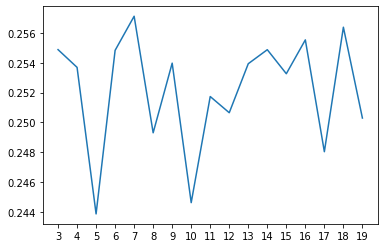

In [ ]:
plt.plot(topics_nr, coherence_values_gensim)

In [ ]:
# To analyse the results, the user can print the list of topics for different topic nr

In [ ]:
# print topics for nr of topics = 15 - I put here parameters for better accuracy as this will be 
# the model used to do the rest of calculations - takes approx 15min to run
numtopics = 7
#model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=numtopics, chunksize = 100, passes = 10, eval_every = None)
model = gensim.models.ldamulticore.LdaMulticore(corpus, id2word=id2word, num_topics=numtopics, iterations = 400, chunksize = 2000, passes = 20)

In [ ]:
topic_print_advanced_options = model.print_topics(num_words=30)

In [ ]:
df_topic_print_advanced_options = pd.DataFrame(topic_print_advanced_options, columns=['topic_id','words'])

In [ ]:
df_topic_print_advanced_options.to_csv(output_folder +'/advanced_topics.csv')

# Topic visualisation

## Data Preparation

In [ ]:
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
!wget https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py

--2020-07-15 08:19:46--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/jscode-test-2.js
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219774 (215K) [text/plain]
Saving to: ‘jscode-test-2.js’

jscode-test-2.js    100%[===================>] 214.62K  --.-KB/s    in 0.04s   

2020-07-15 08:19:46 (4.99 MB/s) - ‘jscode-test-2.js’ saved [219774/219774]

--2020-07-15 08:19:47--  https://raw.githubusercontent.com/DHARPA-Project/TopicModelling-/master/vis-files/tm_1/tm1_data_prepare_gensim.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awa

In [ ]:
%%capture
!pip install funcy

In [ ]:
%run -i tm1_data_prepare_gensim

<Figure size 432x288 with 0 Axes>

In [ ]:
data_vis = prepare(model, corpus, id2word, doc_topic_dist=None)

In [ ]:
topic_info = data_vis[1][data_vis[1]['Category'] == 'Default'].copy()

In [ ]:
topic_info['relevance'] = ''

In [ ]:
for i in range(numtopics):
  topic_num = i+1
  data = data_vis.sorted_terms(topic=topic_num, _lambda=.6).copy()
  topic_info = topic_info.append(data)

In [ ]:
# uncomment to show the full output of a topic, replace 'Topic8' by the topic to display
# topic_info[topic_info['Category'] == 'Topic8']

In [ ]:
topic_info.to_csv(output_folder + '/topic_info.csv')

In [ ]:
topic_proportion = data_vis[0].copy()

In [ ]:
topic_proportion['proportion'] = topic_proportion['Freq'] / 100

In [ ]:
topic_proportion.index.name = 'topic_id'

In [ ]:
topic_proportion.to_csv(output_folder + '/topic_proportion.csv')

In [ ]:
# download also in Jupyter environment for further processing
topic_info.to_csv('topic_info.csv')
topic_proportion.to_csv('topic_proportion.csv')

In [ ]:
%%capture
import notebook.nbextensions
notebook.nbextensions.install_nbextension('topic_info.csv', user=True)
notebook.nbextensions.install_nbextension('topic_proportion.csv', user=True)

## Visualisation

In [ ]:
from IPython.display import display, HTML
from IPython.core.display import Javascript

In [ ]:
display(HTML('<style>@import url("https://fonts.googleapis.com/css2?family=Fira+Sans:wght@300&display=swap");#vis_tm_1{width:40%; margin-left:20%}.svg-container{position:relative;width:100%;vertical-align:top;overflow:hidden;margin:0;padding:0;}.svg-content-responsive{margin:0;padding:0;display:inline-block;position:absolute;top:0;left:0}.line_style{stroke:"rgb(70, 130, 180,.3)";stroke-width:1}.svg_h1{font-size:.9em}.svg_h1,.svg_h2{font-family:"Fira Sans",Arial}.svg_h2{font-size:.6em}.svg_text{font-size:.8em}.svg_text,.svg_text_2{font-family:"Fira Sans",Arial}.svg_text_2{font-size:.7em}.svg_text_3{font-family:"Fira Sans";font-size:.6em}.select_box{width:30%;padding-left:1em;font-family:"Fira Sans",Arial}.select_box select{width:100%;background-color:#fff;padding:.5em .6em;box-shadow:inset 0 1px 3px #ddd;vertical-align:middle;font-family:"Fira Sans",Arial,sans-serif;letter-spacing:.01em;line-height:1.15;-webkit-writing-mode:horizontal-tb!important;text-rendering:auto;color:#000;letter-spacing:normal;word-spacing:normal;text-transform:none;text-indent:0;text-shadow:none;display:inline-block;text-align:start;-webkit-appearance:menulist;align-items:center;white-space:pre;-webkit-rtl-ordering:logical;background-color:#f8f8f8;cursor:default;margin:0;font:400 11px system-ui;border-radius:5px;border:1px solid #a6a6a6;border-image:none;border-image:initial}.select_box select:focus{border-color:#fff;outline:0;box-shadow:inset 0 1px 1px rgba(0,0,0,.075),0 0 1px rgba(102,175,233,.2)}</style>'))
display(HTML('<div id="vis_tm_1"></div>'))
Javascript(filename='jscode-test-2.js')

<IPython.core.display.Javascript object>

# Topic distribution

## 3.1. Distribution per topic and per document

In [ ]:
%%capture
ldamodel = model

In [ ]:
doc_topic_weights = ldamodel.inference(corpus)[0]
doc_topic_dists = doc_topic_weights / doc_topic_weights.sum(axis=1)[:, None]

In [ ]:
distribution_gensim = pd.DataFrame(doc_topic_dists,columns=[f'topic{i}' for i in range(numtopics)])

In [ ]:
distribution_gensim.index.name = 'document'

In [ ]:
# add file names and publication name
distribution_gensim_wfiles = distribution_gensim.copy()
distribution_gensim_wfiles.insert(0, 'document_path', corpus_df['file_name'])
distribution_gensim_wfiles.insert(1, 'publication_name', corpus_df['publication_name'])
distribution_gensim_wfiles

,document_path,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6
document,,,,,,,,,
0,2012271201_1904-03-26_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000210,0.000210,0.998740,0.000210,0.000210,0.000210,0.000210
1,2012271201_1912-06-15_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000133,0.000132,0.000133,0.000133,0.999205,0.000133,0.000133
2,2012271201_1905-04-15_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000211,0.000210,0.998736,0.000211,0.000211,0.000211,0.000211
3,2012271201_1905-01-07_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000221,0.000220,0.998673,0.000221,0.000221,0.000221,0.000221
4,2012271201_1915-09-11_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.999024,0.000162,0.000163,0.000163,0.000163,0.000163,0.000163
...,...,...,...,...,...,...,...,...,...
766,2012271201_1904-08-13_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000197,0.000196,0.000196,0.000196,0.000196,0.998822,0.000196
767,2012271201_1911-12-16_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.184678,0.234336,0.000126,0.580483,0.000126,0.000126,0.000126
768,2012271201_1913-02-08_ed-1_seq-1_ocr.txt,Cronaca Sovversiva,0.000118,0.000118,0.000118,0.000118,0.000118,0.999293,0.000118


## 3.2. Distribution per topic for the whole corpus

In [ ]:
corpus_df['doc_length'] = corpus_df['doc_prep_nostop'].apply(lambda x: len(x))

In [ ]:
topic_frequency = distribution_gensim.mul(corpus_df['doc_length'], axis=0).sum()

In [ ]:
topic_proportion = (topic_frequency / topic_frequency.sum()*100).sort_values(ascending=False)

In [ ]:
topic_proportion

topic0    34.046987
topic6    16.431835
topic3    14.796134
topic2    13.702214
topic5    12.280730
topic4     8.368068
topic1     0.374032
dtype: float64

In [ ]:
# dataframe with values to sort them by order of importance
distribution_df_gensim = pd.DataFrame(topic_proportion, columns=['weight'])

In [ ]:
distribution_df_gensim.index.name = "topics"

In [ ]:
distribution_df_gensim.to_csv(output_folder + '/topic_distribution.csv')

In [ ]:
topics = distribution_df_gensim.index.array

Text(0.5, 0, 'Weight (%)')

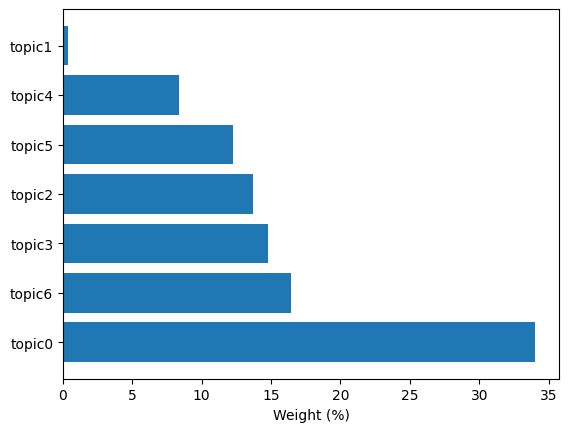

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(topics, distribution_df_gensim['weight'], align='center')
ax.set_xlabel('Weight (%)')

### 3.3. Distribution per publication


In [ ]:
import re
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
gensim_groupby2 = distribution_gensim_wfiles.copy()

In [ ]:
distribution_title = gensim_groupby2.groupby(['publication_name']).mean().reset_index()
#distribution_title['publication'] = distribution_title['publication'].apply(lambda x: get_pub_name(x))

In [ ]:
distribution_title

,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,Cronaca Sovversiva,0.320579,0.003863,0.141522,0.153137,0.088396,0.123237,0.169265


In [ ]:
distribution_title.to_csv(output_folder + '/distribution_per_publication.csv')

In [ ]:
#restructuring df so that it can work with seaborn
df_vis2 = pd.DataFrame(columns=['publication', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_title.columns)-1
for i in range(len(distribution_title)):
  for j in range(columns_nr):
    df_vis2.loc[x] = ''
    df_vis2['publication'].loc[x] = distribution_title['publication_name'].loc[i]
    df_vis2['topic_id'].loc[x] = distribution_title.columns[j+1]
    df_vis2['distribution'].loc[x] = distribution_title.iloc[i,(j+1)]
    x+= 1

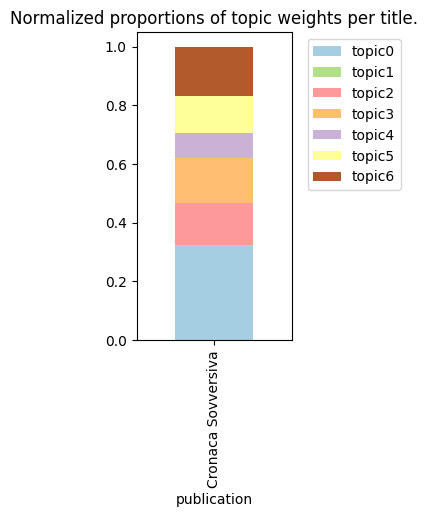

In [ ]:
df_vis2.pivot('publication','topic_id', 'distribution')\
.plot(kind='bar', stacked=True, colormap='Paired', 
      figsize=(2,4), title='Normalized proportions of topic weights per title.')\
.legend(bbox_to_anchor=(1.75, 1))

# Topics weight over time

## 4.1 Aggregate document weights

In [ ]:
# grouping data per month

In [ ]:
distribution_gensim_wfiles['date'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_date(x))
distribution_gensim_wfiles['year'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_year(x))
distribution_gensim_wfiles['month'] = distribution_gensim_wfiles['document_path'].apply(lambda x: get_month(x))

In [ ]:
gensim_groupby = distribution_gensim_wfiles.copy()

In [ ]:
# drop columns that won't be needed at this stage
gensim_groupby = gensim_groupby.drop(['document_path', 'date'], axis=1)

In [ ]:
# group by year 
distribution_year = gensim_groupby.groupby(['year']).mean().reset_index()

In [ ]:
distribution_year

,year,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,1903,0.202957,0.037954,0.147532,0.132289,0.122215,0.142865,0.214187
1,1904,0.098965,0.000195,0.195024,0.142785,0.102285,0.257519,0.203227
2,1905,0.224038,0.000213,0.191157,0.249535,0.131060,0.093647,0.110351
3,1906,0.106803,0.000212,0.091697,0.194622,0.205460,0.159970,0.241235
4,1907,0.153370,0.005429,0.283360,0.201960,0.077019,0.060182,0.218680
5,1908,0.083920,0.011500,0.153823,0.194843,0.021751,0.225558,0.308605
6,1909,0.262194,0.000132,0.098084,0.214865,0.130011,0.182588,0.112127
7,1910,0.132947,0.004107,0.145135,0.169506,0.093886,0.158431,0.295987
8,1911,0.175237,0.006961,0.207177,0.168234,0.080973,0.084812,0.276604
9,1912,0.538990,0.000139,0.107682,0.053522,0.125193,0.129443,0.045033


In [ ]:
distribution_year.to_csv(output_folder + '/distribution_per_year.csv')

## 4.2 Monthly average of normalized weight per topic

### 4.2.1. Line chart view 

In [ ]:
#restructuring df so that it can work with seaborn
df_vis = pd.DataFrame(columns=['time', 'topic_id', 'distribution'])
x=0
columns_nr = len(distribution_year.columns)-2
for i in range(len(distribution_year)):
  for j in range(columns_nr):
    df_vis.loc[x] = ''
    df_vis['time'].loc[x] = distribution_year['year'].loc[i]
    df_vis['topic_id'].loc[x] = distribution_year.columns[j+1]
    df_vis['distribution'].loc[x] = distribution_year.iloc[i,(j+1)]
    x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


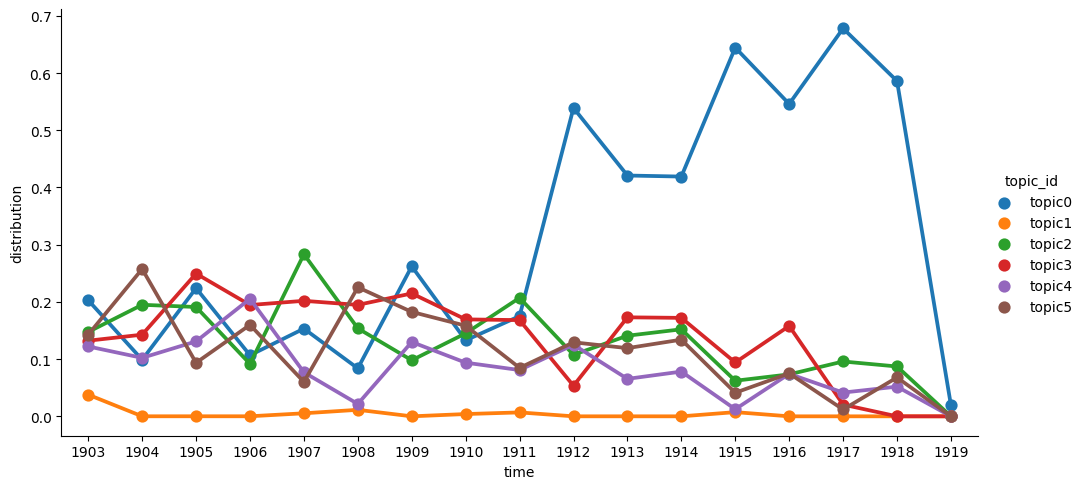

In [ ]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.2. Bar chart view

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


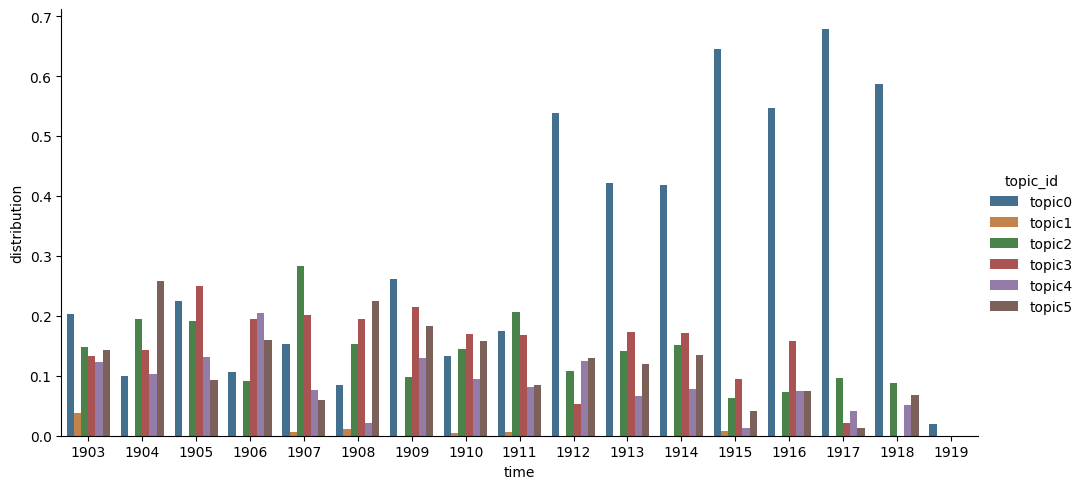

In [ ]:
sns.factorplot(data= df_vis, 
               x= 'time',
               y= 'distribution',
               kind= 'bar',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)

### 4.2.3. Topic weights per title over time



In [ ]:
gensim_groupby3 = distribution_gensim_wfiles.copy()

In [ ]:
distribution_title_time = gensim_groupby3.groupby(['year','publication_name']).mean().reset_index()

In [ ]:
distribution_title_time

,year,publication_name,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,1903,Cronaca Sovversiva,0.202957,0.037954,0.147532,0.132289,0.122215,0.142865,0.214187
1,1904,Cronaca Sovversiva,0.098965,0.000195,0.195024,0.142785,0.102285,0.257519,0.203227
2,1905,Cronaca Sovversiva,0.224038,0.000213,0.191157,0.249535,0.131060,0.093647,0.110351
3,1906,Cronaca Sovversiva,0.106803,0.000212,0.091697,0.194622,0.205460,0.159970,0.241235
4,1907,Cronaca Sovversiva,0.153370,0.005429,0.283360,0.201960,0.077019,0.060182,0.218680
5,1908,Cronaca Sovversiva,0.083920,0.011500,0.153823,0.194843,0.021751,0.225558,0.308605
6,1909,Cronaca Sovversiva,0.262194,0.000132,0.098084,0.214865,0.130011,0.182588,0.112127
7,1910,Cronaca Sovversiva,0.132947,0.004107,0.145135,0.169506,0.093886,0.158431,0.295987
8,1911,Cronaca Sovversiva,0.175237,0.006961,0.207177,0.168234,0.080973,0.084812,0.276604
9,1912,Cronaca Sovversiva,0.538990,0.000139,0.107682,0.053522,0.125193,0.129443,0.045033


In [ ]:
distribution_title_time.to_csv(output_folder + 'distribution_per_publication_over_time.csv')

### 4.2.4. Rolling average

#### 4.2.4.1. Rolling average by topic

In [ ]:
rolling_mean = distribution_year.rolling(2).mean()

In [ ]:
rolling_mean.to_csv(output_folder + 'rolling_mean.csv')

In [ ]:
#restructuring df so that it can work with seaborn
df_vis3 = pd.DataFrame(columns=['time', 'topic_id', 'rolling_mean'])
x=0
columns_nr = len(rolling_mean.columns)-2
for i in range(len(rolling_mean)):
  for j in range(columns_nr):
    if ( rolling_mean.iloc[i,(j+1)] > 0 ):
      df_vis3.loc[x] = ''
      df_vis3['time'].loc[x] = distribution_year['year'].loc[i]
      df_vis3['topic_id'].loc[x] = rolling_mean.columns[j+1]
      df_vis3['rolling_mean'].loc[x] = rolling_mean.iloc[i,(j+1)]
      x+= 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


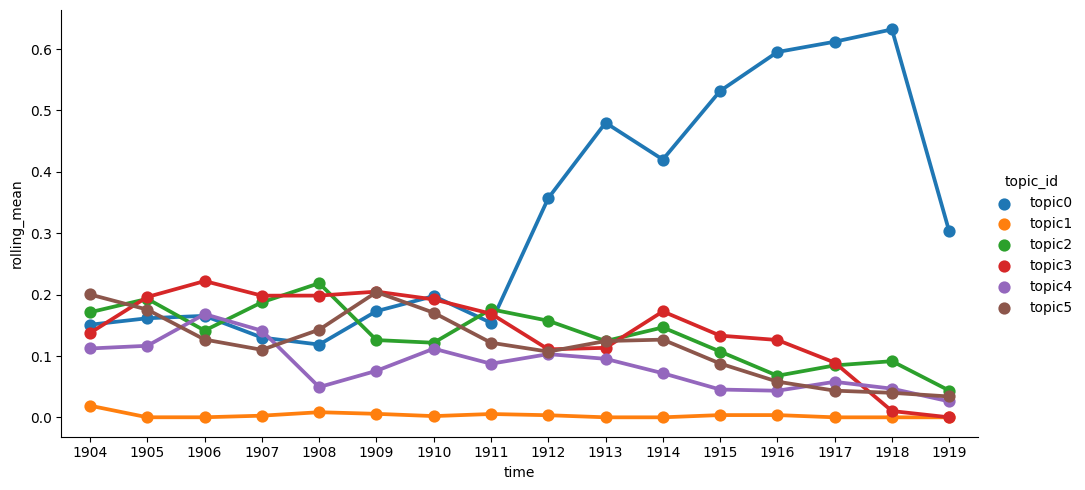

In [ ]:
sns.factorplot(data= df_vis3, 
               x= 'time',
               y= 'rolling_mean',
               hue = 'topic_id',
               aspect=2,
               saturation=.5)